In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import numpy as np
from matplotlib import cm
import seaborn as sns
from  matplotlib.colors import LinearSegmentedColormap


2023-07-26 14:17:11.349369: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 14:17:11.385030: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 14:17:11.385988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 14:17:12.041234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
image_size = (16, 16) #(544, 512) (744,646)
batch_size = 32
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "Kernels_16x16/train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

#test_ds = tf.keras.utils.image_dataset_from_directory(
#    "Kernels_16x16/test",
#    seed=3337,
#    image_size=image_size,
#    batch_size=batch_size,
#)


Found 14561 files belonging to 2 classes.
Using 11649 files for training.
Using 2912 files for validation.


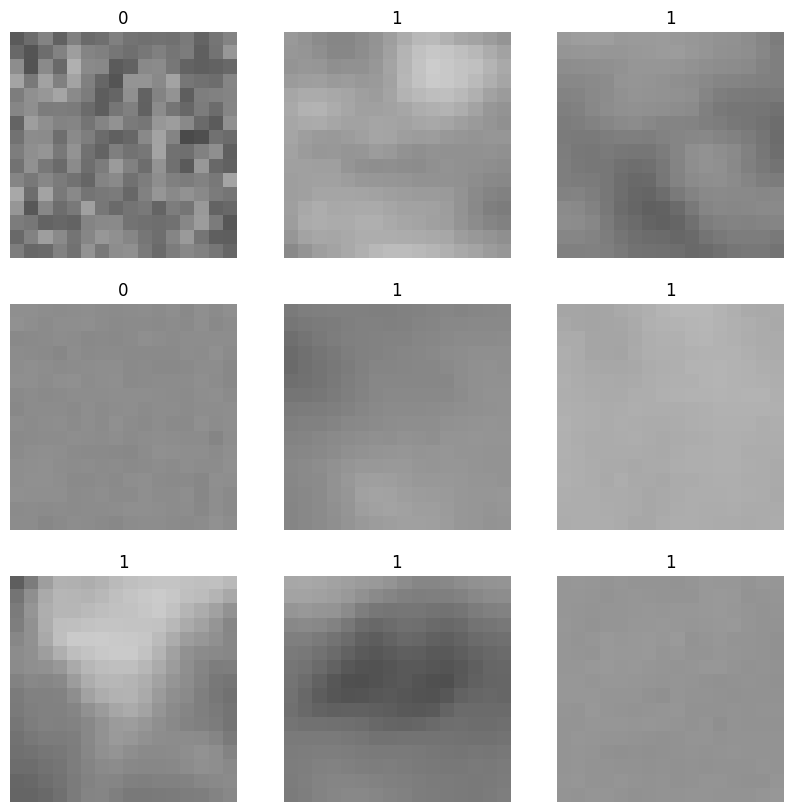

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [5]:
data_augmentation = keras.Sequential(
    [
#        layers.RandomFlip("horizontal"),
#        layers.RandomRotation(0.1),
    ]
)


In [6]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)


    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [32, 64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    
    
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)


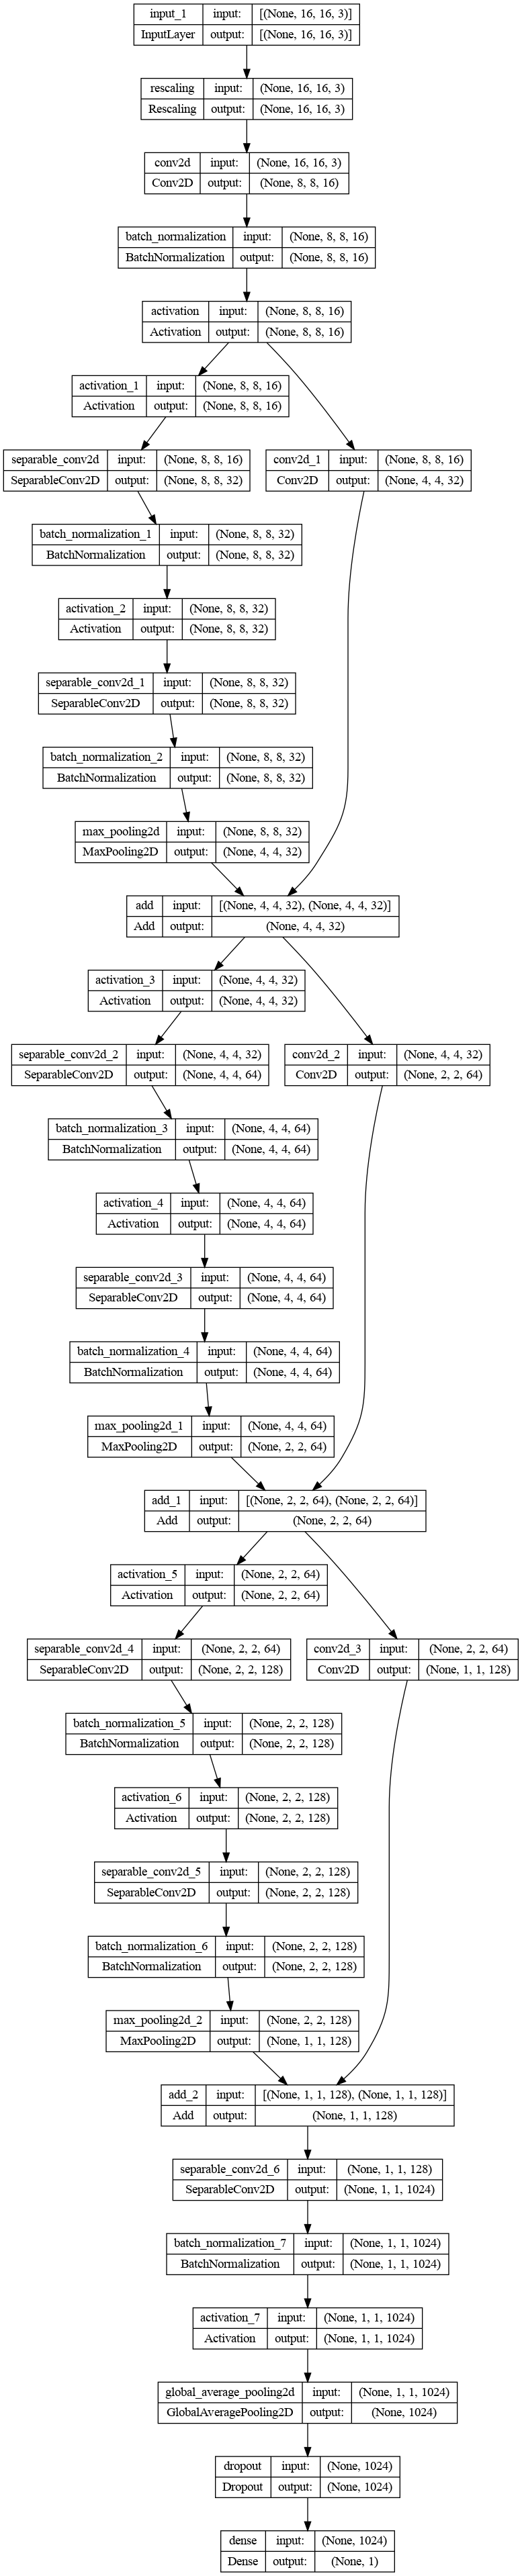

In [8]:
keras.utils.plot_model(model, show_shapes=True)


In [11]:

epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [12]:
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25
365/365 [==============================] - 5s 8ms/step - loss: 0.0892 - accuracy: 0.9609 - val_loss: 0.2180 - val_accuracy: 0.9341
Epoch 2/25
365/365 [==============================] - 3s 8ms/step - loss: 0.0855 - accuracy: 0.9629 - val_loss: 0.1274 - val_accuracy: 0.9526
Epoch 3/25
365/365 [==============================] - 3s 8ms/step - loss: 0.0843 - accuracy: 0.9648 - val_loss: 0.1400 - val_accuracy: 0.9430
Epoch 4/25
365/365 [==============================] - 3s 8ms/step - loss: 0.0815 - accuracy: 0.9660 - val_loss: 0.1121 - val_accuracy: 0.9567
Epoch 5/25
365/365 [==============================] - 3s 8ms/step - loss: 0.0827 - accuracy: 0.9657 - val_loss: 0.1300 - val_accuracy: 0.9396
Epoch 6/25
365/365 [==============================] - 3s 8ms/step - loss: 0.0753 - accuracy: 0.9666 - val_loss: 0.0952 - val_accuracy: 0.9540
Epoch 7/25
365/365 [==============================] - 3s 8ms/step - loss: 0.0743 - accuracy: 0.9681 - val_loss: 0.1186 - val_accuracy: 0.9602
Epoch 

# Identifying Outliers

In [13]:
import glob
outliers = []
count = 0
for i in glob.glob("Kernels_16x16/test/*.png"):
    count += 1
    img = keras.utils.load_img(i, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array, verbose=0)
    score = float(predictions[0])

    clear_score = 100 * (1 - score)
    cloudy_score = 100 * score
    
    if (clear_score < 50):
        outliers.append(f"{i} {clear_score:.2f}% clear and {cloudy_score:.2f}% cloud.")
        #plt.figure(figsize=(1, 1))
        #plt.imshow(img)
        #plt.title(f"{i} {clear_score:.2f}% clear and {cloudy_score:.2f}% cloud.")
        #plt.axis("off")
print(count)

3775


1678


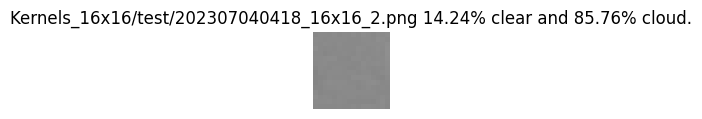

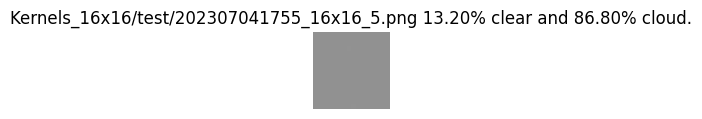

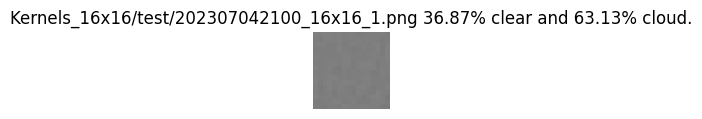

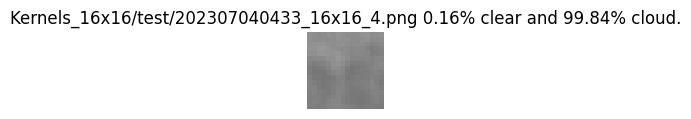

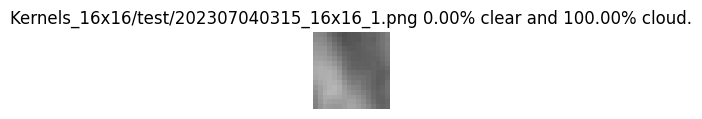

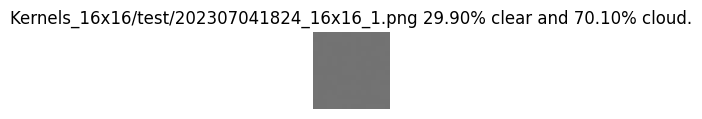

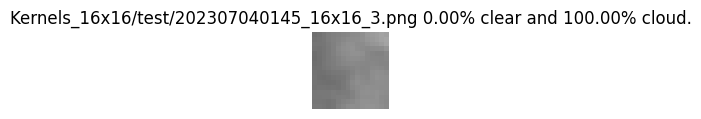

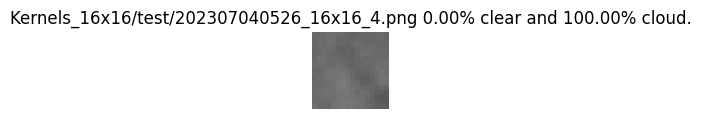

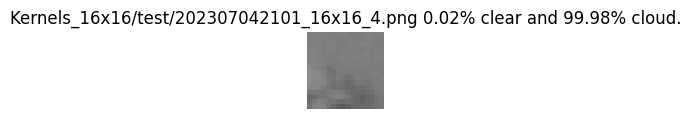

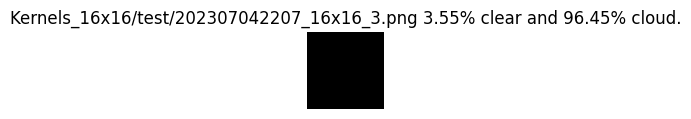

In [14]:
for i, item in enumerate(outliers):
    if(i < 10):
        filename = item.split(" ")[0]
        img = keras.utils.load_img(filename, target_size=image_size)
        plt.figure(figsize=(1, 1))
        plt.imshow(img)
        plt.title(item)
        plt.axis("off")
    else:
        break
print(len(outliers))

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

pred = model.predict(test_ds, verbose=0)
file_paths = test_ds.file_paths
f = open("predictions.txt", "w")
for i in range(len(pred)):
    f.write(str(file_paths[i]) + ' ')
    for j in range(len(pred[i])):
        f.write(str(pred[i, j]) + ' ')
    f.write('\n')
f.close()
print(pred)

val_labels = tf.concat([y for x, y in test_ds], axis=0).numpy()
#print(pred)
#print(val_labels)
fpr, tpr, thresholds = roc_curve(val_labels, pred)
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

NameError: name 'test_ds' is not defined

# Apply Model To Create Heatmap

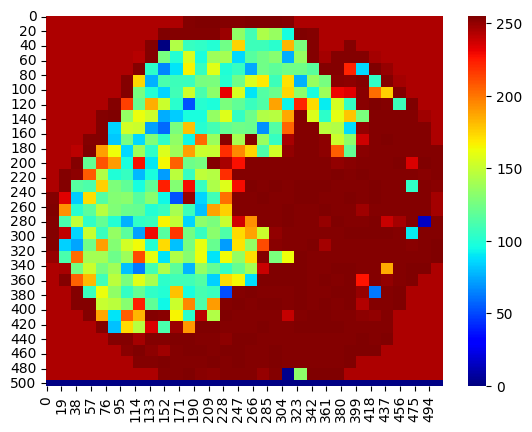

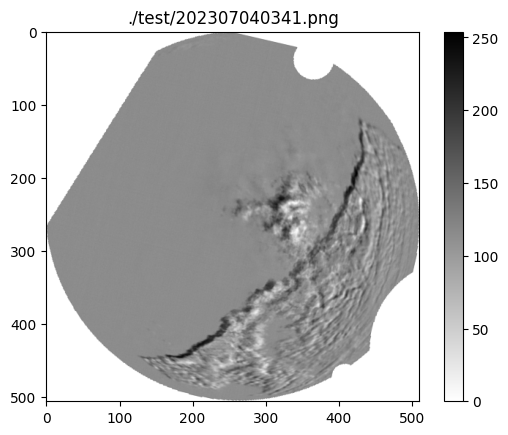

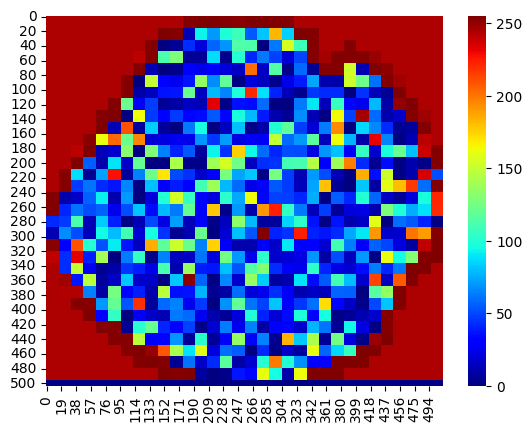

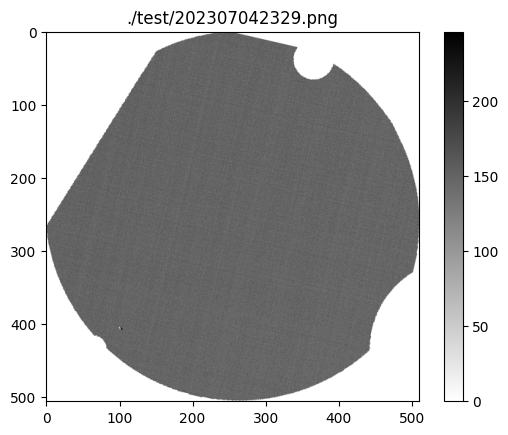

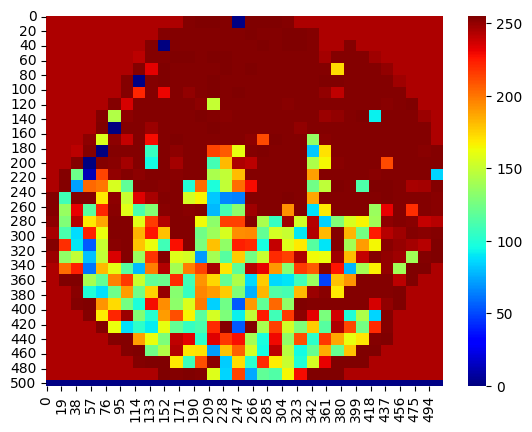

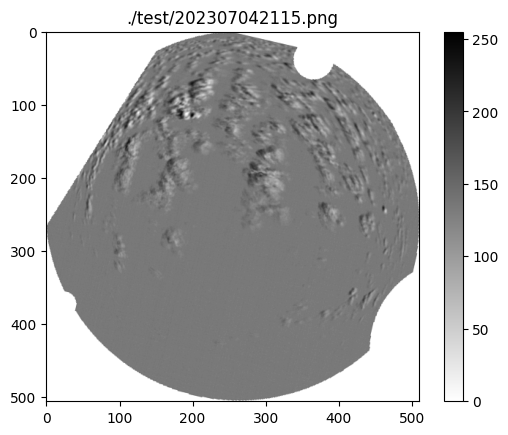

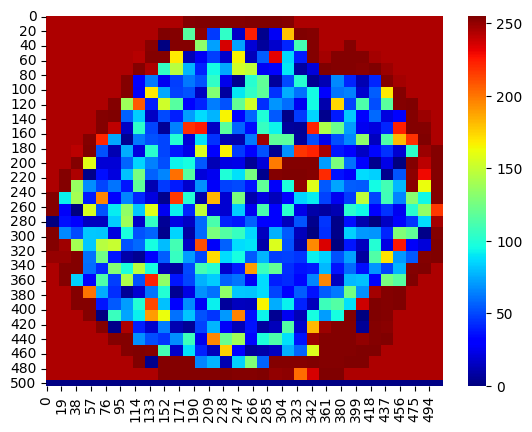

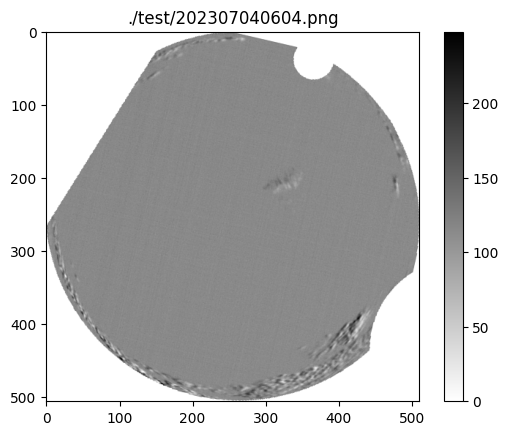

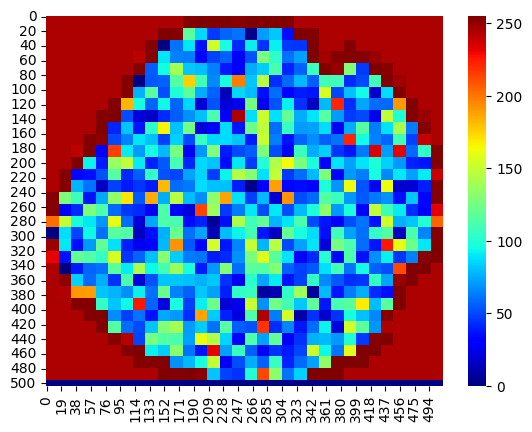

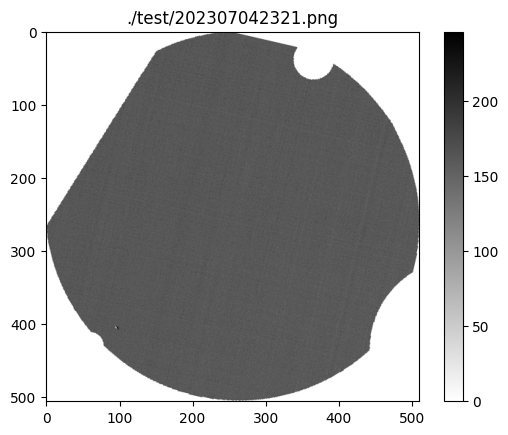

In [ ]:
#apply to cloudy image

IW = 512
IH = 504

size = 8 #side length of kernel from center. 16x16 for size=8
maxSqrSize = 145 #length from center to edge
midx = IW/2
midy = IH/2

#load image
folder="./test"


for i in range(10):

    a=random.choice(os.listdir(folder))

    file = folder+'/'+a
    im = Image.open(file)

#im = Image.open("./train/cloudy/202302042354a.png")

    imc = im
    x_locs = np.arange(size, IW, size * 2)
    y_locs = np.arange(size, IH, size * 2)

    heatmap = np.empty([IH, IW])

    for y in y_locs:
        for x in x_locs:
            imk = imc.crop((x-size, y-size, x+size, y+size))
            imk.save("tmp.png")
            img = keras.utils.load_img("tmp.png", target_size=image_size)
            img_array = keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)  # Create batch axis
        
            predictions = model.predict(img_array, verbose = 0)
            score = float(predictions[0])

            clear_score = (1 - score)
            cloudy_score = score
            for k_y in range(y-size, y+size):
                for k_x in range(x-size, x+size):
                    heatmap[k_y, k_x] = cloudy_score

    imc_heatmap = Image.fromarray(np.uint8(heatmap*255))
    plt.figure()
    
    sns.heatmap(imc_heatmap, cmap='jet')

    plt.figure()

    plt.title(im.filename)
    plt.imshow(im, cmap='gray_r')
    plt.colorbar()
    
    plt.show()
                    

(array([  5888.,    256.,    256.,    256.,    256.,      0.,   2304.,
        171520.,    768.,  76544.]),
 array([1.22073747e-04, 1.00109866e-01, 2.00097659e-01, 3.00085452e-01,
        4.00073244e-01, 5.00061037e-01, 6.00048829e-01, 7.00036622e-01,
        8.00024415e-01, 9.00012207e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

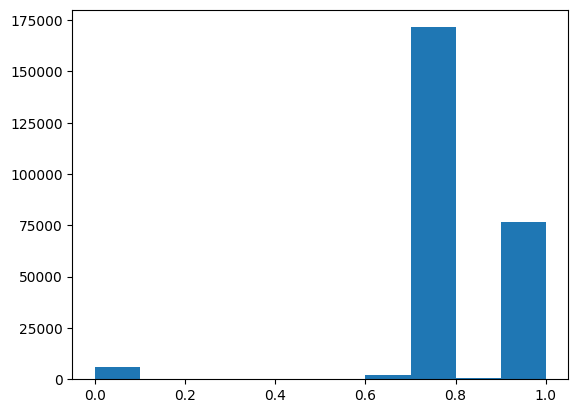

In [21]:
plt.figure()
counts, bins = np.histogram(heatmap)
plt.hist(bins[:-1], bins, weights=counts)

In [53]:
#apply mask to create a more accurate histogram
#add nonmasked values to flattened array
heatmap_filtered = np.ma.array(heatmap, mask=high_mask)
tmp = np.ma.filled(heatmap_filtered, fill_value=-1)
vals = np.zeros(IW * IH)
for i in range(len(tmp)):
    for j in range(len(tmp[0])):
        if(tmp[i, j] != -1):
            #add pixel value to vals
            vals[-1] = tmp[i, j]
counts, bins = np.histogram(vals)
plt.hist(bins[:-1], bins, weights=counts)

/home/billy/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:810: RuntimeWarning: overflow encountered in scalar divide
  norm = n_equal_bins / _unsigned_subtract(last_edge, first_edge)
/home/billy/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:838: RuntimeWarning: invalid value encountered in multiply
  f_indices = _unsigned_subtract(tmp_a, first_edge) * norm
/home/billy/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in cast
  indices = f_indices.astype(np.intp)


IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 11

In [54]:
#calculate percentage cloud coverage. Iterate through image 
#and for a given threshold value set value above to 1 and values below to 0 then average the array
heatmap_filtered = np.ma.array(heatmap, mask=high_mask)
th = 0.3
tmp = np.ma.filled(heatmap_filtered, fill_value=-1)
cloud_count = 0
total = 0
for i in range(len(tmp)):
    for j in range(len(tmp[0])):
        if(tmp[i, j] != -1):
            #increment
            total += 1
            if(tmp[i, j] >= th):
                cloud_count += 1
        
print("percentage cloud coverage = " + str(cloud_count / total))


percentage cloud coverage = 0.9501039501039501
